In [3]:
import os
import requests
import json
import yfinance as yf
from bs4 import BeautifulSoup
from lxml import etree
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly.offline import plot
import requests
import pandas as pd
import numpy as np
import datetime
import json
import time

### Define Some Useful Functions for Feature Engineering

In [4]:
# financial indicator functions
# note that these are indented to work with ONE key value
# ex. ONLY DATES means that we must group by stock ticker
# note: TICKERS will not make sense for these functions as keys

def check_series_numeric(column) -> bool:
    not_numeric = column.apply(pd.to_numeric, errors = 'coerce').isna().all()
    # if the data is not numeric, the test failed 
    return not not_numeric

def calculate_sma(column, period = 10):
    if not check_series_numeric(column):
        return column
    sma = column.rolling(period).mean()
    return pd.Series(sma, index= column.index, name = 'SMA')

def calculate_ema(column, period = 10):
    if not check_series_numeric(column):
        return column
    ema = column.ewm(span = period, min_periods = period - 1).mean()
    return pd.Series(ema, index = column.index, name = 'EMA')

def calculate_rsi_helper(column, period = 14, use_exponential = False):
    if not check_series_numeric(column):
        return column 

    column = column.astype(float)
    # find differences in prices
    differences = column.diff() 

    # clip, but center off of zero value
    gain = differences.clip(lower = 0.01)
    loss = differences.clip(upper = -0.01)

    avg_gain = gain.mean()
    avg_loss = loss.mean()

    if use_exponential:
        # get the exponential weighted mean of the very last element in this current rolling window
        avg_gain = gain.ewm(span = period, min_periods = period - 1).mean().iloc[-1]
        avg_loss = loss.ewm(span = period, min_periods = period - 1).mean().iloc[-1]

    RS = avg_gain / avg_loss 
    RSI = 100 - 100 / (1 - RS)

    return RSI

'''
    let RS = average gain / average loss   
    RSI = 100 - 100 / (1 - RS)

    some things to look out for: 
        - using exponential weighted means on the average
            gains and losses made the RSI value much more
            sensitive and fluctuating more based on price
            changes
        - using simple averages made the RSI value more 
            smoothed out

    keyword argument options:
        - period: type int
        - use_exponential: type bool

'''
def calculate_rsi(column, period, use_exponential):
    rsi = column.rolling(14).apply(lambda x: calculate_rsi_helper(x, period=period, use_exponential=use_exponential)).astype(float)
    return pd.Series(rsi, index = column.index, name = 'RSI')

'''
    MACD (moving average convergence/ divergence) shows the relationship
    between two exponential moving averages and comparing this to the 
    9-day EMA line 

    MACD = 12-period EMA - 26-period EMA 
    Signal = 9-period EMA - 26-period EMA
'''
def calculate_macd(column, long_period = 26, short_period = 12, signal_period = 9) -> tuple[object, object]:
    if not check_series_numeric(column):
        return column 
    
    # Calculate the short and long EMAs
    ewm_short = column.ewm(span=short_period, min_periods=short_period-1).mean()
    ewm_long = column.ewm(span=long_period, min_periods=long_period-1).mean()

    # Calculate MACD line
    macd = (ewm_short - ewm_long).astype(float)

    # Calculate the Signal line (EMA of MACD)
    ewm_signal = macd.ewm(span=signal_period, min_periods=signal_period-1).mean()
    signal = ewm_signal.astype(float)

    # Return both MACD and Signal as pandas Series
    macd = pd.Series(macd, index=column.index, name='MACD')
    signal = pd.Series(signal, index=column.index, name='MACD-SIGNAL')

    return macd, signal

"""
    Calculate the average stock price between 30 and 45 days after the present day.
    Expects that data is given in sorted order by date.

    - data: pd.DataFrame with stock data indexed by date.
    - column_name: str, the column name containing the stock prices.
    This returns the average stock price between 30 and 45 days after the present day.
"""
def calculate_future_average_stock_price(column, start_period=30, end_period=45):
    # Initialize a new series to store the future averages
    future_averages = []

    # Iterate over the series to calculate the future average for each index
    for i in range(len(column)):
        # The future range is from i+30 to i+45 (exclusive of 45)
        if i >= len(column) - end_period:
            future_averages.append(None)
            continue

        future_values = column.iloc[i + start_period : i + end_period]

        future_price = future_values.mean()
        price_change = future_price - column.iloc[i]
        percent_change = price_change / column.iloc[i] * 100
        future_averages.append(percent_change)
    
    # Return the result as a new series
    return pd.Series(future_averages, index=column.index, name="FutureAverage")

### Some Useful Utility Functions Used Throughout the Project

In [5]:
""" 
    Data cleaning and feature engineering the tickers dataframe:
        - I only ned to know Adj Close and Volume numbers for relevant metrics per each stock
        - The stocks of interest are:
            - Stock that I am predicting for trading
            - Probably some other related stocks (2-6 of them)
            - Global market conditions indicators
"""
def extract_tickers_ticker(
        tickers_df: pd.DataFrame, tickers: list[str], 
        start: datetime.datetime, end: datetime.datetime) -> pd.DataFrame:

    res_df = tickers_df[tickers]
    cols_to_keep = set(["Adj Close", "Volume"])
    remapped_columns = [f"{outer}:{inner}" for outer, inner in res_df.columns]
    apple_cols_to_keep = ["Ticker:Price"] + \
        [f"{outer}:{inner}" for outer, inner in res_df.columns if inner in cols_to_keep]
    res_df.columns = remapped_columns
    res_df = res_df[apple_cols_to_keep]
    res_df = res_df.iloc[1:]
    res_df["Ticker:Price"] = pd.to_datetime(res_df["Ticker:Price"])
    res_df = res_df[(res_df["Ticker:Price"] >= start) & (res_df["Ticker:Price"] <= end)]
    res_df = res_df.set_index("Ticker:Price").rename_axis("Date")

    return res_df

def parse_technical_indicators(
        tickers_df: pd.DataFrame, tickers: list[str],
        start: datetime.datetime, end: datetime.datetime,
        short_period: int = 15, long_period: int = 30) -> pd.DataFrame:
    
    res_df = extract_tickers_ticker(tickers_df, tickers, start, end)

    # get the Y value: future average stock price
    res_df["future_avg_price"] = calculate_future_average_stock_price(res_df["AAPL:Adj Close"])
    cols = res_df.columns
    for colname in cols:
        if "Volume" in colname:
            # get the ewn of volumes
            res_df[colname + "_ewm_short"] = res_df[colname].ewm(span=short_period, adjust=False).mean()
            res_df[colname + "_ewm_long"] = res_df[colname].ewm(span=long_period, adjust=False).mean()
        elif "Adj Close" in colname:
            # get RSI & MACD signal difference otherwise
            res_df[colname + "_rsi"] = calculate_rsi(res_df[colname], period=14, use_exponential=True)
            macd, signal = calculate_macd(res_df[colname])
            res_df[colname + "_macd"] = macd
            res_df[colname + "_signal"] = signal

    return res_df

def extract_congressional_trades_ticker(congressional_df: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:

    res_df = filter_congressional_trades_ticker(congressional_df, tickers)
    res_df["disclosure_date"] = pd.to_datetime(res_df["disclosure_date"])

    res_df["type"] = res_df["type"].str.lower()
    res_df = res_df[~res_df["type"].str.contains("exchange")]

    res_df["type"] = res_df["type"].str.contains("purchase", na=False) # True if purchase
    smmap = {True: "purchase", False: "sale"}
    res_df["type"] = res_df["type"].map(smmap)

    res_df.set_index("disclosure_date", inplace=True)

    res_df = res_df[["ticker", "type", "amount"]]

    res_df["count"] = 1
    res_df = res_df.pivot_table(
        columns="type", 
        values="count", 
        aggfunc="sum", 
        index=["disclosure_date", "ticker"],
        ).fillna(0)

    res_df = res_df.rename_axis(columns=None).reset_index()
    res_df = res_df.set_index("disclosure_date")

    return res_df

def filter_congressional_trades_ticker(congressional_df: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    filtered_df = congressional_df[congressional_df["ticker"].notna()]
    filtered_df = filtered_df[filtered_df["ticker"].str.contains('|'.join(tickers))]
    filtered_df.drop(["Unnamed: 0"], inplace=True, axis=1)
    return filtered_df

### Some Useful Functions for Data Visualization

In [52]:
# plotting the technical indicators of volume, RSI, and MACD_diff
def plot_technical_indicators(
        stock_data_df: pd.DataFrame, start: datetime.datetime, end: datetime.datetime,
        ticker_name: str) -> None:
    ticker_name = ticker_name.upper()
    plot_df = stock_data_df[(stock_data_df.index >= start) & (stock_data_df.index <= end)]

    trace_price = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close"], mode='lines', name='Price')
    trace_rsi = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close_rsi"], mode='lines', name='RSI')
    trace_overbought = go.Scatter(x=plot_df.index, y=[70] * len(plot_df), mode='lines', name='Overbought', line=dict(color='red', dash='dash'))
    trace_oversold = go.Scatter(x=plot_df.index, y=[30] * len(plot_df), mode='lines', name='Oversold', line=dict(color='green', dash='dash'))
    trace_macd = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close_macd"], mode='lines', name='MACD')
    trace_signal = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close_signal"], mode='lines', name='Signal')

    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02,
                        subplot_titles=["Stock Price", "RSI", "MACD"])

    fig.add_trace(trace_price, row=1, col=1)
    fig.add_trace(trace_rsi, row=2, col=1)
    fig.add_trace(trace_overbought, row=2, col=1)
    fig.add_trace(trace_oversold, row=2, col=1)
    fig.add_trace(trace_macd, row=3, col=1)
    fig.add_trace(trace_signal, row=3, col=1)

    fig.update_layout(
        title_text=f"${ticker_name} Technical Indicators",
        title_font=dict(color="white", size=20),
        
        # Dark background settings
        plot_bgcolor="#1c1c1c",  # Dark background for the plot area
        paper_bgcolor="#121212",  # Dark background for the surrounding area
        
        # Axes and gridline settings
        xaxis=dict(
            showgrid=True,
            gridcolor="#444444",  # Gridline color
            tickangle=45,
            tickmode="array",
            tickfont=dict(color="white")
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor="#444444",  # Gridline color
            tickfont=dict(color="white"),
        ),
        
        # Additional customizations for ticks, labels, etc.
        font=dict(color="white"),  # Set general text color to white
        height=800, width=800
    )
    
    # pip install -U kaledio
    pio.renderers.default = "png"
    fig.show()

# for macd, if the macd line crosses the signal line, that is a bullish crossover
# if the macd line crosses below the signal line, that is a bearish crossover

def plot_congressional_trades_bar(congressional_df: pd.DataFrame, tickers: list[str]) -> None:
    """ 
        Given the raw congressional trading dataframe, plot the frequency of trades
        for either a sale or a purchase of the stock. This function will naively assume
        that any type of purchase is a "buy", whereas any type of sell is a "sell",
        despite the fact that there are more subleties to this where one can either
        partially buy or sell a stock at varying exchange amounts.
    """

    ## some data exploration on the apple congressional data
    filtered_df = filter_congressional_trades_ticker(congressional_df, tickers)

    summarized_cong_df = filtered_df.groupby(["amount", "type"]).size().reset_index()
    summarized_cong_df.columns = ["amount", "type", "count"]
    unique_amounts = summarized_cong_df["amount"].unique()
    unique_amounts_sorted = sorted(unique_amounts, key=lambda x: \
        int([str_x for str_x in x.replace('$', '').replace(',', '').split(' ') if str_x.isnumeric()][-1]))

    summarized_cong_df["type"] = summarized_cong_df["type"].str.lower()
    # i am not considering "exchange" as a valid trade option
    summarized_cong_df = summarized_cong_df[~summarized_cong_df["type"].str.contains("exchange")]
    summarized_cong_df["type"] = summarized_cong_df["type"].str.contains("purchase", na=False) # True if purchase
    smmap = {True: "purchase", False: "sale"}
    summarized_cong_df["type"] = summarized_cong_df["type"].map(smmap)

    purchase_types = summarized_cong_df.groupby(["amount", "type"]).sum().reset_index()

    def _extract_purchase_sell(X: pd.DataFrame):
        purchase_amt = X[X["type"].str.contains("purchase")]["count"].sum()
        sell_amt = X[X["type"].str.contains("sale")]["count"].sum()
        return pd.Series([purchase_amt, sell_amt], index=["purchase", "sale"])

    # Dark gray color
    DARKGRAY = "#1c1c1c"
    GREEN = "#46cb46"
    RED = "#e73f3f"

    purchase_types = purchase_types.groupby("amount").apply(_extract_purchase_sell)
    purchase_types = purchase_types.reindex(unique_amounts_sorted)

    fig, ax = plt.subplots()
    bottom = np.zeros(len(unique_amounts))

    for amt_type in ["sale", "purchase"]:
        ax.bar(purchase_types.index, purchase_types[amt_type], label=amt_type, color = GREEN if amt_type == "purchase" else RED, bottom=bottom)
        bottom += purchase_types[amt_type].to_numpy()


    # Create the plot
    fig.patch.set_facecolor(DARKGRAY)
    ax.set_facecolor(DARKGRAY)

    # Add gridlines and customize ticks
    ax.grid(axis="y", linestyle="--", alpha=0.6, color="gray")
    # ax.set_yticks(np.arange(0, max_purchse_amt + 50, 50))
    ax.tick_params(axis="x", rotation=80, colors="white")
    ax.tick_params(axis="y", colors="white")


    # Set title with a line break
    title_text = f"Frequency of Congressional\nTrade Amount Categories For: \n${', '.join(tickers)}"
    ax.set_title(title_text, fontsize=16, weight='bold', color="white", pad=20)

    # Add labels for x and y axes
    ax.set_xlabel("Trade Amount Categories", fontsize=12, color="white")
    ax.set_ylabel("Frequency", fontsize=12, color="white", labelpad=10)

    # Set axis lines (spines) to white
    ax.spines['bottom'].set_color('white')  # X-axis line
    ax.spines['left'].set_color('white')    # Y-axis line
    ax.spines['top'].set_color('white')     # Hide top line
    ax.spines['right'].set_color('white')   # Hide right line

    # Add a legend
    plt.legend(title="Trade Type")

    # Adjust the layout to prevent label clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_congressional_trades_timeseries(
        training_ticker_congressional_df: pd.DataFrame, start: datetime.datetime, end: datetime.datetime,
        ticker: str, title: str = 'Future Avg Price and Transaction Volume Over Time', barwidth: int = 15) -> None:

    sub_df = training_ticker_congressional_df[(training_ticker_congressional_df.index >= start) & \
                                              (training_ticker_congressional_df.index <= end)]

    # Visualize the merged dataframe with congressional and time series insights
    fig, ax1 = plt.subplots(figsize=(14,7))

    ax1.plot(sub_df.index, sub_df['future_avg_price'], label='Future Avg Price', color='blue', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Future Avg Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(title)

    # Create a secondary y-axis for transaction counts
    ax2 = ax1.twinx()

    # Adjust bar width and offsets
    width = np.timedelta64(10, 'D')  # Offset width for separation (10 days)

    # Plot Purchases
    ax2.bar(
        sub_df.index,  # Shift purchases bars to the left
        sub_df[f"purchase_{ticker}"],
        color='green',
        alpha=0.6,
        width=barwidth,  # Reduce bar width
        label='Purchases'
    )

    # Plot Sells
    ax2.bar(
        sub_df.index,  # Shift sells bars to the right
        sub_df[f"sale_{ticker}"],
        color='red',
        alpha=0.6,
        width=barwidth,  # Reduce bar width
        label='Sells'
    )

    # # Set y-axis label for transactions
    ax2.set_ylabel('Transaction Volume', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # # Add legends for both plots
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout()
    plt.show()

### Prepare AAPL Tickers & Technical Indicators

In [8]:
if "tickers_df" not in dir():
    tickers_df = pd.read_csv("./data/stock_ticker_data.csv", header=[0,1])

prediction_ticker = ["Ticker", "AAPL"]
relevant_tickers = ["MSFT", "AMZN", "GOOGL", "META", "NVDA"]
global_market_tickers = ["GC=F", "GLD", "CL=F", "^GSPC", "^VIX", "DX-Y.NYB", "HG=F"]

training_df = parse_technical_indicators(tickers_df, prediction_ticker + relevant_tickers + global_market_tickers,
                       datetime.datetime(2014, 1, 1), datetime.datetime(2023, 1, 1))

# taking a look somewhere in the middle of this dataframe...
training_df.iloc[100:110]

,AAPL:Adj Close,AAPL:Volume,MSFT:Adj Close,MSFT:Volume,AMZN:Adj Close,AMZN:Volume,GOOGL:Adj Close,GOOGL:Volume,META:Adj Close,META:Volume,...,DX-Y.NYB:Adj Close_rsi,DX-Y.NYB:Adj Close_macd,DX-Y.NYB:Adj Close_signal,DX-Y.NYB:Volume_ewm_short,DX-Y.NYB:Volume_ewm_long,HG=F:Adj Close_rsi,HG=F:Adj Close_macd,HG=F:Adj Close_signal,HG=F:Volume_ewm_short,HG=F:Volume_ewm_long
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-28,19.668386,315481600.0,33.929050,25711500.0,15.508000,54520000.0,28.452047,31632000.0,63.319351,47795000.0,...,82.268010,0.163706,0.082837,0.0,0.0,57.149754,0.026384,0.021185,746.651578,1065.134806
2014-05-29,20.026762,376474000.0,34.208897,19888200.0,15.689000,47310000.0,28.457535,28222000.0,63.638393,42700000.0,...,71.586279,0.178079,0.101885,0.0,0.0,49.309509,0.024091,0.021767,736.820131,1039.513206
2014-05-30,19.951740,564020800.0,34.717697,34567600.0,15.627500,85204000.0,28.511900,37434000.0,63.109982,45253500.0,...,60.473042,0.177741,0.117056,0.0,0.0,45.161556,0.020624,0.021538,684.342614,992.899451
2014-06-02,19.814634,369350800.0,34.590504,18504300.0,15.442000,44068000.0,28.147303,33210000.0,62.890648,35996000.0,...,70.302560,0.196982,0.133041,0.0,0.0,54.148407,0.021102,0.021451,638.674788,949.422067
2014-06-03,20.094843,292709200.0,34.166500,18068900.0,15.359500,47584000.0,27.657017,40626000.0,62.681274,32217000.0,...,64.079381,0.202635,0.146960,0.0,0.0,47.729535,0.018565,0.020874,589.465439,903.975482
2014-06-04,20.324303,335482000.0,34.191936,23209000.0,15.339000,42142000.0,27.619610,34582000.0,63.149864,36514000.0,...,69.109968,0.214324,0.160433,0.0,0.0,40.041064,0.012218,0.019143,554.657259,865.718999
2014-06-05,20.404051,303805600.0,34.946674,31865200.0,16.178499,155934000.0,28.176729,35868000.0,63.000313,47352000.0,...,49.485060,0.197115,0.167769,0.0,0.0,40.751111,0.006907,0.016695,517.325102,826.382290
2014-06-06,20.347939,349938400.0,35.175640,24060500.0,16.483500,104880000.0,28.231594,34804000.0,62.312386,42442000.0,...,51.421188,0.184575,0.171130,0.0,0.0,36.478462,-0.000364,0.013284,505.409464,800.293110
2014-06-09,20.673534,301660000.0,34.997555,15019200.0,16.375000,64244000.0,28.466015,30594000.0,62.691242,37617000.0,...,61.645812,0.191788,0.175262,0.0,0.0,37.801890,-0.006654,0.009296,474.608281,765.370973


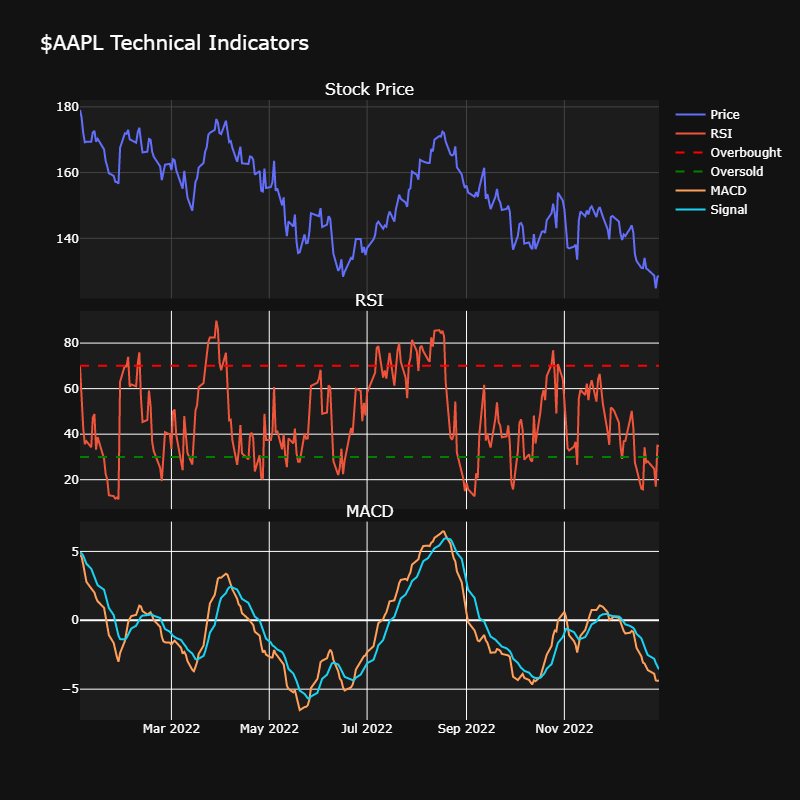

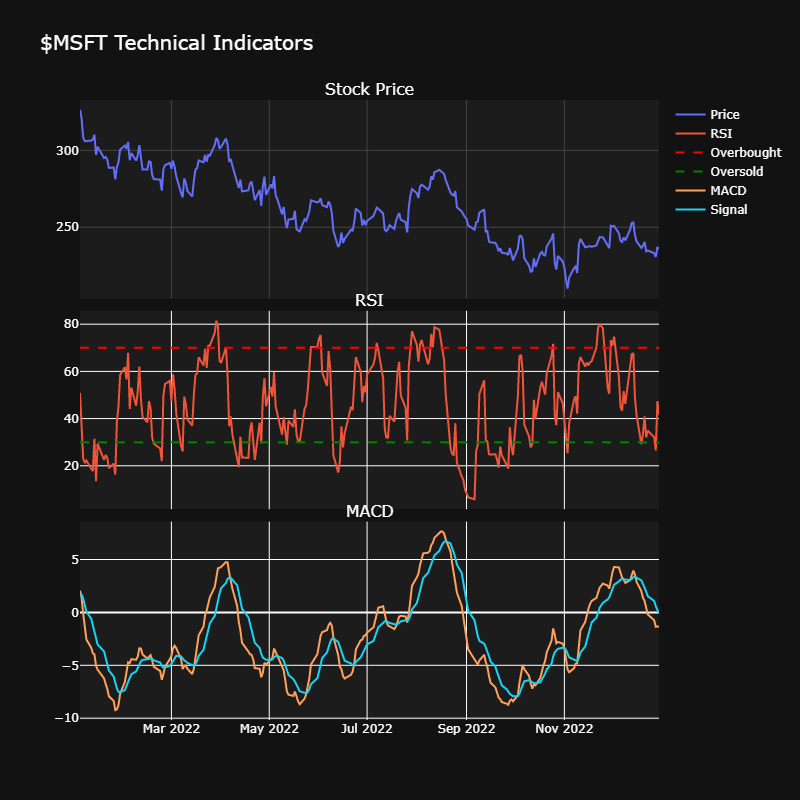

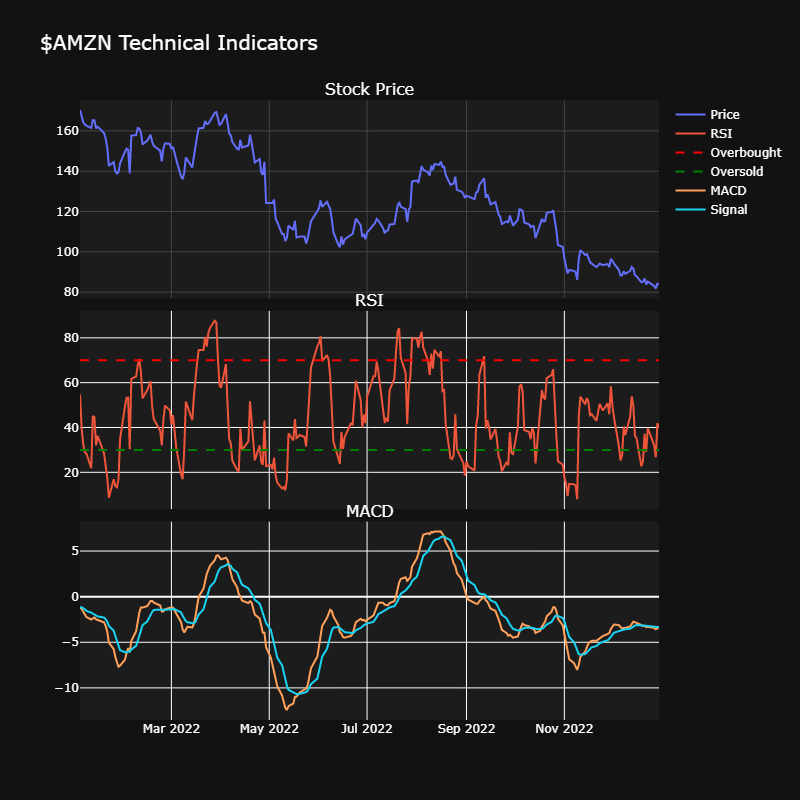

In [9]:
# take a view at what the technical indicator data looks like:
plot_technical_indicators(training_df, datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), "aapl")
plot_technical_indicators(training_df, datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), "msft")
plot_technical_indicators(training_df, datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), "amzn")

### Preparing Congressional Trade Data for AAPL

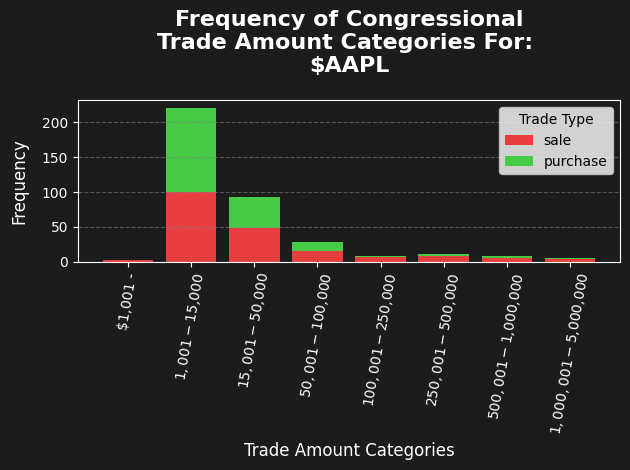

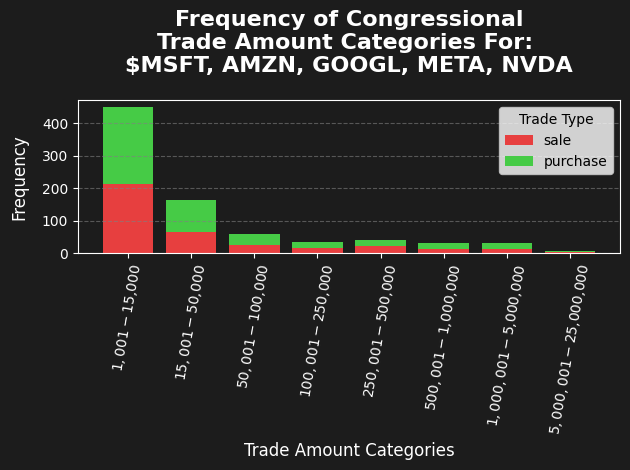

In [11]:
if "congressional_df" not in dir():
    congressional_df = pd.read_csv("./data/congressional_data.csv")

# understand how many relevant purchases and sales there are for each stock type
# we will be creating some sort of metric to quantify these congressional trading activities
plot_congressional_trades_bar(congressional_df, ["AAPL"])
plot_congressional_trades_bar(congressional_df, ["MSFT", "AMZN", "GOOGL", "META", "NVDA"])

In [30]:
training_congressional_df = extract_congressional_trades_ticker(congressional_df, ["AAPL"] + relevant_tickers)

training_congressional_df

,ticker,purchase,sale
disclosure_date,,,
2014-01-31,MSFT,1.0,0.0
2014-02-05,MSFT,1.0,0.0
2014-02-11,MSFT,1.0,0.0
2014-02-27,AAPL,0.0,1.0
2014-03-26,AAPL,0.0,1.0
...,...,...,...
2023-05-11,META,0.0,1.0
2023-05-11,MSFT,0.0,1.0
2023-05-11,NVDA,1.0,0.0


### Merging Tickers and Congressional Trading Data Together

In [ ]:
is_aapl = (training_congressional_df["ticker"] == "AAPL")

aapl_congressional_df = training_congressional_df[is_aapl]
aapl_congressional_df.columns = ["ticker", "purchase_aapl", "sale_aapl"]
aapl_congressional_df.drop("ticker", axis=1, inplace=True)
support_congressional_df = training_congressional_df[~is_aapl]
support_congressional_df.columns = ["ticker", "purchase_support", "sale_support"]
support_congressional_df.drop("ticker", axis=1, inplace=True)

# there will be MANY NaN values in this dataframe because of the fact that there are a lot less
# congressional trades than there are stock data points. Imputation / feature engineering will be
# necessary down the line
training_ticker_congressional_df = pd.merge(
    training_df,
    aapl_congressional_df,
    left_index=True,
    right_index=True,
    how="left"
)

training_ticker_congressional_df = pd.merge(
    training_ticker_congressional_df,
    support_congressional_df,
    left_index=True,
    right_index=True,
    how="left"
)

# fill in all NaN values with zeros
training_ticker_congressional_df["purchase_aapl"].fillna(0, inplace=True)
training_ticker_congressional_df["sale_aapl"].fillna(0, inplace=True)
training_ticker_congressional_df["purchase_support"].fillna(0, inplace=True)
training_ticker_congressional_df["sale_support"].fillna(0, inplace=True)

# finally, get rid of unecessary columns. we denoted useful columns with the _ keyword
keep_cols = [c for c in training_ticker_congressional_df.columns if '_' in c]


training_ticker_congressional_df = training_ticker_congressional_df[keep_cols[1:] + [keep_cols[0]]]

C:\Users\abhin\AppData\Local\Temp\ipykernel_3624\368453449.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\abhin\AppData\Local\Temp\ipykernel_3624\368453449.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



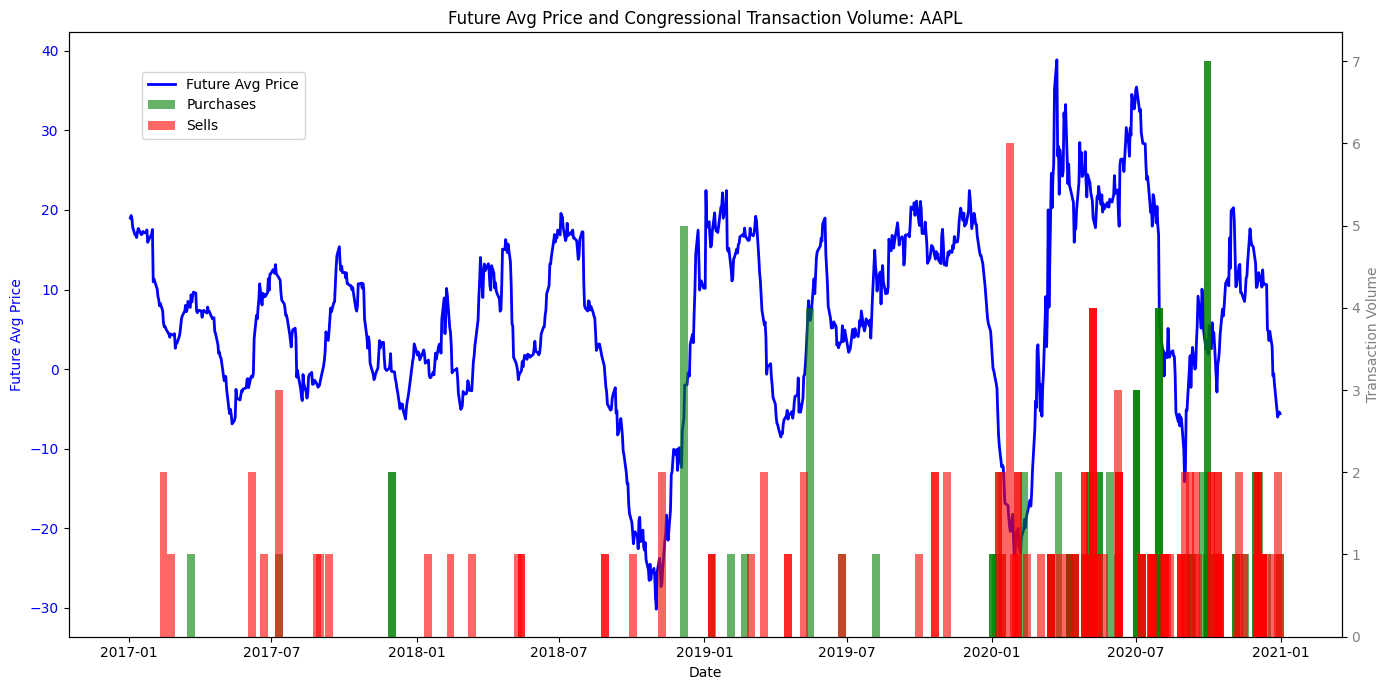

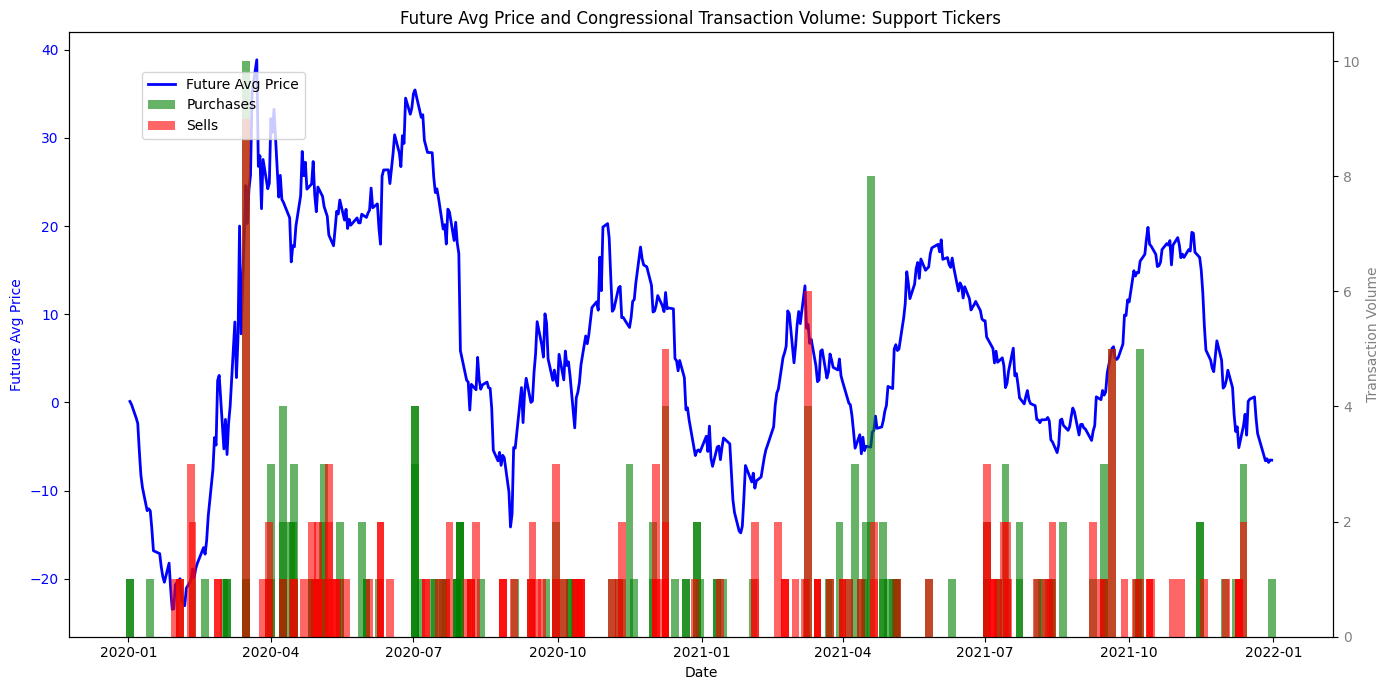

In [ ]:
plot_congressional_trades_timeseries(
    training_ticker_congressional_df, start=datetime.datetime(2017, 1, 1), end=datetime.datetime(2021, 1, 1), ticker="aapl",
    barwidth=10, title="AAPL Future Avg Price and Congressional Transaction Volume: AAPL" 
)

plot_congressional_trades_timeseries(
    training_ticker_congressional_df, start=datetime.datetime(2020, 1, 1), end=datetime.datetime(2022, 1, 1), ticker="support",
    barwidth=5, title="AAPL Future Avg Price and Congressional Transaction Volume: Support Tickers"
)

In [22]:
training_ticker_congressional_df["purchase_aapl"].unique()

array([0.])

Analyzing Transaction Trends Over Time and by Political Party

This code performs the following analyses:
1. Displays the monthly trading activity for all transaction types, showing temporal patterns.
2. Visualizes monthly trading activity broken down by transaction type (e.g., purchase, sell) specifically for the Republican Party.
3. Similar analysis as above but focused on the Democratic Party, highlighting differences or similarities in their trading patterns.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure disclosure_date is in datetime format
df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], format='%Y-%m-%d')

# Add columns for Year and Month
df['Year'] = df['disclosure_date'].dt.year
df['Month'] = df['disclosure_date'].dt.to_period('M')  # Year-Month format

# Group by Month and Transaction Type
monthly_trends = df.groupby(['Month', 'type'])['type'].count().unstack(fill_value=0)

# Plot Transaction Trends Over Time (All Types)
plt.figure(figsize=(12, 6))
monthly_trends.plot(kind='line', figsize=(12, 6), marker='o', title='Transaction Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid()
plt.show()

# Group by Political Party and Transaction Type
party_trends = df.groupby(['Month', 'party', 'type']).size().unstack(fill_value=0)

# Example: Plot Trends for Republicans
republican_trends = party_trends.loc[party_trends.index.get_level_values('party') == 'Republican']
republican_trends.droplevel('party').plot(kind='line', figsize=(12, 6), marker='o', title='Republican Transaction Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid()
plt.show()

# Example: Plot Trends for Democrats
democrat_trends = party_trends.loc[party_trends.index.get_level_values('party') == 'Democrat']
democrat_trends.droplevel('party').plot(kind='line', figsize=(12, 6), marker='o', title='Democrat Transaction Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid()
plt.show()


Analyzing Transaction Activity by Sector

This code visualizes congressional trading activity by sector, highlighting:
1. Total transaction counts per sector to identify the most traded industries.
2. Trends over time for the top 5 sectors, showing temporal patterns in trading behavior.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Grouping by sector and calculating the transaction counts
sector_summary = df.groupby('sector')['type'].value_counts().unstack(fill_value=0)

# Plotting total transaction counts per sector
plt.figure(figsize=(12, 6))
sector_summary.sum(axis=1).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Total Transactions by Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyzing trends over time for top 5 sectors
top_sectors = sector_summary.sum(axis=1).sort_values(ascending=False).head(5).index

# Filtering data for top sectors
top_sectors_data = df[df['sector'].isin(top_sectors)]

# Grouping by sector and date for trends
sector_trends = top_sectors_data.groupby(['disclosure_date', 'sector'])['type'].count().unstack(fill_value=0)

# Plotting trends
sector_trends.plot(figsize=(14, 7))
plt.title('Transaction Trends Over Time for Top 5 Sectors')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Data Exploration: Understanding Correlations and Clustering Tendency of Our Stock Market Data

In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')


# Filter for rows with valid transaction data
valid_data_df = merged_df[
    (merged_df['type'].apply(lambda x: len(x) > 0)) | 
    (merged_df['amount'].apply(lambda x: len(x) > 0))
]

# Clean the Data
valid_data_df['rsi'] = valid_data_df['rsi'].fillna(valid_data_df['rsi'].mean())
valid_data_df['macd_diff'] = valid_data_df['macd_diff'].fillna(valid_data_df['macd_diff'].mean())

# Ensure 'type' and 'amount' are not empty
valid_data_df['type'] = valid_data_df['type'].apply(lambda x: [0] if not x else x)
valid_data_df['amount'] = valid_data_df['amount'].apply(lambda x: [0] if not x else x)

# Feature Engineering
# Add temporal features
valid_data_df['Year'] = valid_data_df['Date'].dt.year
valid_data_df['Month'] = valid_data_df['Date'].dt.month
valid_data_df['Day'] = valid_data_df['Date'].dt.day
valid_data_df['Quarter'] = valid_data_df['Date'].dt.quarter
valid_data_df['is_weekend'] = valid_data_df['Date'].dt.weekday >= 5

# Create lagged features and rolling averages
valid_data_df['price_t-1'] = valid_data_df['future_avg_price'].shift(1)
valid_data_df['7_day_rolling_avg'] = valid_data_df['future_avg_price'].rolling(window=7).mean()
valid_data_df['price_pct_change'] = valid_data_df['future_avg_price'].pct_change()

# Encode transaction types and map 'amount' ranges
valid_data_df['type_encoded'] = valid_data_df['type'].apply(lambda x: sum(x))
amount_mapping = {
    '$1,001 - $15,000': 1,
    '$15,001 - $50,000': 2,
    '$50,001 - $100,000': 3,
    '$100,001 - $250,000': 4,
    '$250,001 - $500,000': 5,
    '$500,001 - $1,000,000': 6,
}
valid_data_df['amount_numeric'] = valid_data_df['amount'].apply(
    lambda x: [amount_mapping.get(i, 0) for i in x]
)

# Add momentum indicators
valid_data_df['rsi_above_50'] = valid_data_df['rsi'] > 50
valid_data_df['macd_positive'] = valid_data_df['macd_diff'] > 0

# Create interaction features
valid_data_df['rsi_macd_interaction'] = valid_data_df['rsi'] * valid_data_df['macd_diff']
valid_data_df['price_rsi_interaction'] = valid_data_df['future_avg_price'] * valid_data_df['rsi']

# Normalize or Scale Numerical Data
scaler = StandardScaler()
numeric_cols = ['future_avg_price', 'price_t-1', '7_day_rolling_avg', 'rsi', 'macd_diff']
valid_data_df[numeric_cols] = scaler.fit_transform(valid_data_df[numeric_cols])

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Histogram of RSI
valid_data_df['rsi'].plot(kind='hist', bins=30, title='Histogram of RSI', alpha=0.7)
plt.show()


In [ ]:
# Rolling Average vs Actual Prices
valid_data_df[['future_avg_price', '7_day_rolling_avg']].plot(title='Actual Prices vs Rolling Average')
plt.show()

In [ ]:
# RSI vs MACD Interaction
valid_data_df.plot(x='rsi', y='macd_diff', kind='scatter', title='RSI vs MACD', alpha=0.7)
plt.show()